In [300]:
from IPython.display import display as iDisplay, Markdown, Latex
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from helpers import get_immediate_subdirectories
from helpers import get_immediate_files
from helpers import timestamp_to_unix_milliseconds

pd.options.mode.chained_assignment = None  # default='warn'

# Best Current Solution

1. Downsample positions within a window average and sliding rate
2. Get velocity and acceleration
3. Use a metric like mean and standard deviation to identify moments of velocity difference.

In [422]:
def Downsample(df, ms_col, val_cols, window_ms=500, slide_ms=250, include_dt:bool=False, method:str='mean'):
    # Initialize an empty list to store downsampled results
    downsampled_data = []
    
    # Sort rows to make sure they are in time order
    df2 = df.sort_values(ms_col)
    
    # Start sliding the window
    start_time = df2[ms_col].min()

    while start_time + window_ms <= df2[ms_col].max():
        # Get the subset of data in the current window
        end_time = start_time + window_ms
        window_data = df2[(df2[ms_col] >= start_time) & (df2[ms_col] < end_time)]
        
        if not window_data.empty:
            downsampled_row = {
                ms_col: end_time,
            }
            if include_dt:
                downsampled_row['dt'] = window_data['dt'].sum()
            for val_col in val_cols:
                if method == 'max':
                    downsampled_row[val_col] = window_data[val_col].max()
                elif method == 'min':
                    downsampled_row[val_col] = window_data[val_col].min()
                else:
                    downsampled_row[val_col] = window_data[val_col].mean()
            downsampled_data.append(downsampled_row)

        # Slide the window
        start_time += slide_ms

    # Convert the downsampled data into a DataFrame
    downsampled_df = pd.DataFrame(downsampled_data)
    return downsampled_df

def CalculateVelocities(original_df, reverse_x:bool=True):
    df = original_df.copy() # Deep copy
    
    # Calculate displacements. Apply -1 to X due to Unity shenanigans
    df['diff_pos_x'] = df['pos_x'].diff().fillna(0)
    if reverse_x: df['diff_pos_x'] = df['diff_pos_x'] * -1.0
    df['diff_pos_y'] = df['pos_y'].diff().fillna(0)
    df['diff_pos_z'] = df['pos_z'].diff().fillna(0)
    df['displacement'] = np.sqrt(df['diff_pos_x']**2 + df['diff_pos_z']**2)
    
    # Calculate speed and velocity
    df['velocity'] = df['displacement'] / df['dt']
    df['velocity'] = df['velocity'].fillna(0)
    df['velocity_x'] = df['diff_pos_x'] / df['dt']
    df['velocity_x'] = df['velocity_x'].fillna(0)
    df['velocity_y'] = df['diff_pos_y'] / df['dt']
    df['velocity_y'] = df['velocity_y'].fillna(0)
    df['velocity_z'] = df['diff_pos_z'] / df['dt']
    df['velocity_z'] = df['velocity_z'].fillna(0)
    
    # Return new df
    return df

def CalculateAccelerations(original_df, downsample=True):
    # copy to prevent mutation
    df = original_df.copy()
    
    # Calculating Accelerations
    df['accel'] = df['velocity'].diff().fillna(0) / df['dt']
    df['accel'] = df['accel'].replace([np.inf, -np.inf], 0).fillna(0)
    df['accel_x'] = df['velocity_x'].diff().fillna(0) / df['dt']
    df['accel_x'] = df['accel_x'].replace([np.inf, -np.inf], 0).fillna(0)
    df['accel_z'] = df['velocity_z'].diff().fillna(0) / df['dt']
    df['accel_z'] = df['accel_z'].replace([np.inf, -np.inf], 0).fillna(0)
    
    # If necessary, downsample
    if downsample:
        df = Downsample(df, ms_col='trial_seconds', val_cols=['accel','accel_x','accel_z'], window_ms=0.5, slide_ms=0.25, include_dt=True)
    
    # Calculate Jerks
    df['accel^2'] = df['accel'].diff().fillna(0) / df['dt']
    df['accel^2'] = df['accel^2'].replace([np.inf, -np.inf], 0).fillna(0)
    df['accel_x^2'] = df['accel_x'].diff().fillna(0) / df['dt']
    df['accel_x^2'] = df['accel_x^2'].replace([np.inf, -np.inf], 0).fillna(0)
    df['accel_z^2'] = df['accel_z'].diff().fillna(0) / df['dt']
    df['accel_z^2'] = df['accel_z^2'].replace([np.inf, -np.inf], 0).fillna(0)
    
    # Return results
    return df


In [442]:
_ACCEPTED_PARTICIPANTS = {
    'p1':['jay-vr-2'],
    'p2':['jay-vr-1','jay-vr-4'],
    'p6':['jay-vr-1','jay-vr-2'],
    'p7':['jay-vr-1','jay-vr-2'],
    'p8':['jay-vr-3'],
    'p9':['jay-vr-1','jay-vr-2'],
    'p10':['jay-vr-3'],
    'p11':['jay-vr-1','jay-vr-2','jay-vr-3'],
    'p12':['jay-vr-2','jay-vr-3'],
    'p14':['jay-vr-1','jay-vr-2','jay-vr-3'],
    'p15':['jay-vr-2','jay-vr-3'],
    'p16':['jay-vr-1','jay-vr-2','jay-vr-3','jay-vr-4'],
    'p17':['jay-vr-1','jay-vr-2','jay-vr-3'],
    'p18':['jay-vr-1','jay-vr-2','jay-vr-3']
}

_ALIGNED_DIR = './samples/participant_data_aligned/p6/jay-vr-1'

_ALIGNED_FILES = { os.path.basename(f):os.path.join(_ALIGNED_DIR, f) for f in get_immediate_files(_ALIGNED_DIR)}
for key,val in _ALIGNED_FILES.items(): print(key,'\t\t',val)

.DS_Store 		 ./samples/participant_data_aligned/p6/jay-vr-1/.DS_Store
user-aligned.csv 		 ./samples/participant_data_aligned/p6/jay-vr-1/user-aligned.csv
pedestrians-aligned.csv 		 ./samples/participant_data_aligned/p6/jay-vr-1/pedestrians-aligned.csv
eeg_trial-normed.png 		 ./samples/participant_data_aligned/p6/jay-vr-1/eeg_trial-normed.png
eeg-aligned.csv 		 ./samples/participant_data_aligned/p6/jay-vr-1/eeg-aligned.csv
trial.csv 		 ./samples/participant_data_aligned/p6/jay-vr-1/trial.csv
eeg_conc-normed.png 		 ./samples/participant_data_aligned/p6/jay-vr-1/eeg_conc-normed.png
eeg_rest-normed.png 		 ./samples/participant_data_aligned/p6/jay-vr-1/eeg_rest-normed.png
raw_eeg.csv 		 ./samples/participant_data_aligned/p6/jay-vr-1/raw_eeg.csv


In [443]:
# Read user position data
user_df = pd.read_csv(_ALIGNED_FILES['user-aligned.csv'])

# Ensure no duplicates, and sort by trial milliseconds
user_df = user_df.groupby(['pos_x','pos_y','pos_z'],as_index=False).first().sort_values(by=['trial_milliseconds'])
user_df = user_df[user_df['trial_milliseconds'].between(0,50000)]

# User metrics for comparison
user_df['trial_seconds'] = user_df['trial_milliseconds'] / 1000;
user_df['dt'] = user_df['trial_seconds'].diff().fillna(0)
# Conduct all calculations necessary for velocity and acceleration for the original data
#user_df = CalculateVelocities(user_df, reverse_x=False)
user_df['velocity'] = user_df['velocity_x'] + user_df['velocity_z']
user_df = CalculateAccelerations(user_df, downsample=False)

# Downsample positions. Here, we use window size of 0.5-sec, slide=0.2-sec
"""
player_df = Downsample(
    user_df, 
    ms_col='trial_milliseconds', 
    val_cols=['pos_x','pos_y','pos_z'], window_ms=250, slide_ms=250, method='mean')
player_df['trial_seconds'] = player_df['trial_milliseconds'] / 1000;
player_df['dt'] = player_df['trial_seconds'].diff().fillna(0)
player_df = CalculateVelocities(player_df, reverse_x=True)
player_df = CalculateAccelerations(player_df, downsample=False)
"""
player_df = Downsample(
    user_df, 
    ms_col='trial_milliseconds', 
    val_cols=['velocity','velocity_x','velocity_z'], window_ms=250, slide_ms=250, include_dt=True, method='mean')
player_df = CalculateAccelerations(player_df, downsample=False)

# Original Standard deviation of acceleration and its derivative
orig_accel_x_mean = user_df['accel_x'].mean()
orig_accel_x_std = user_df['accel_x'].std()
orig_accel_x2_mean = user_df['accel_x^2'].mean()
orig_accel_x2_std = user_df['accel_x^2'].std()
orig_accel_z_mean = user_df['accel_z'].mean()
orig_accel_z_std = user_df['accel_z'].std()
orig_accel_z2_mean = user_df['accel_z^2'].mean()
orig_accel_z2_std = user_df['accel_z^2'].std()

# Downsampled sandard deviation of acceleration and its derivative
accel_x_mean = player_df['accel_x'].mean()
accel_x_std = player_df['accel_x'].std()
accel_x2_mean = player_df['accel_x^2'].mean()
accel_x2_std = player_df['accel_x^2'].std()
accel_z_mean = player_df['accel_z'].mean()
accel_z_std = player_df['accel_z'].std()
accel_z2_mean = player_df['accel_z^2'].mean()
accel_z2_std = player_df['accel_z^2'].std()

# Abs. Value the columns for jerk
player_df['abs_accel^2'] = np.absolute(player_df['accel^2'])
player_df['abs_accel_x^2'] = np.absolute(player_df['accel_x^2'])
player_df['abs_accel_z^2'] = np.absolute(player_df['accel_z^2'])

# Detect when the person stops after... maybe 30 seconds
at_0_df = player_df[(player_df['trial_milliseconds'] > 20000) & (player_df['velocity_x'] >= -0.1)]
player_df = player_df[player_df['trial_milliseconds'] <= at_0_df.iloc[0]['trial_milliseconds']]

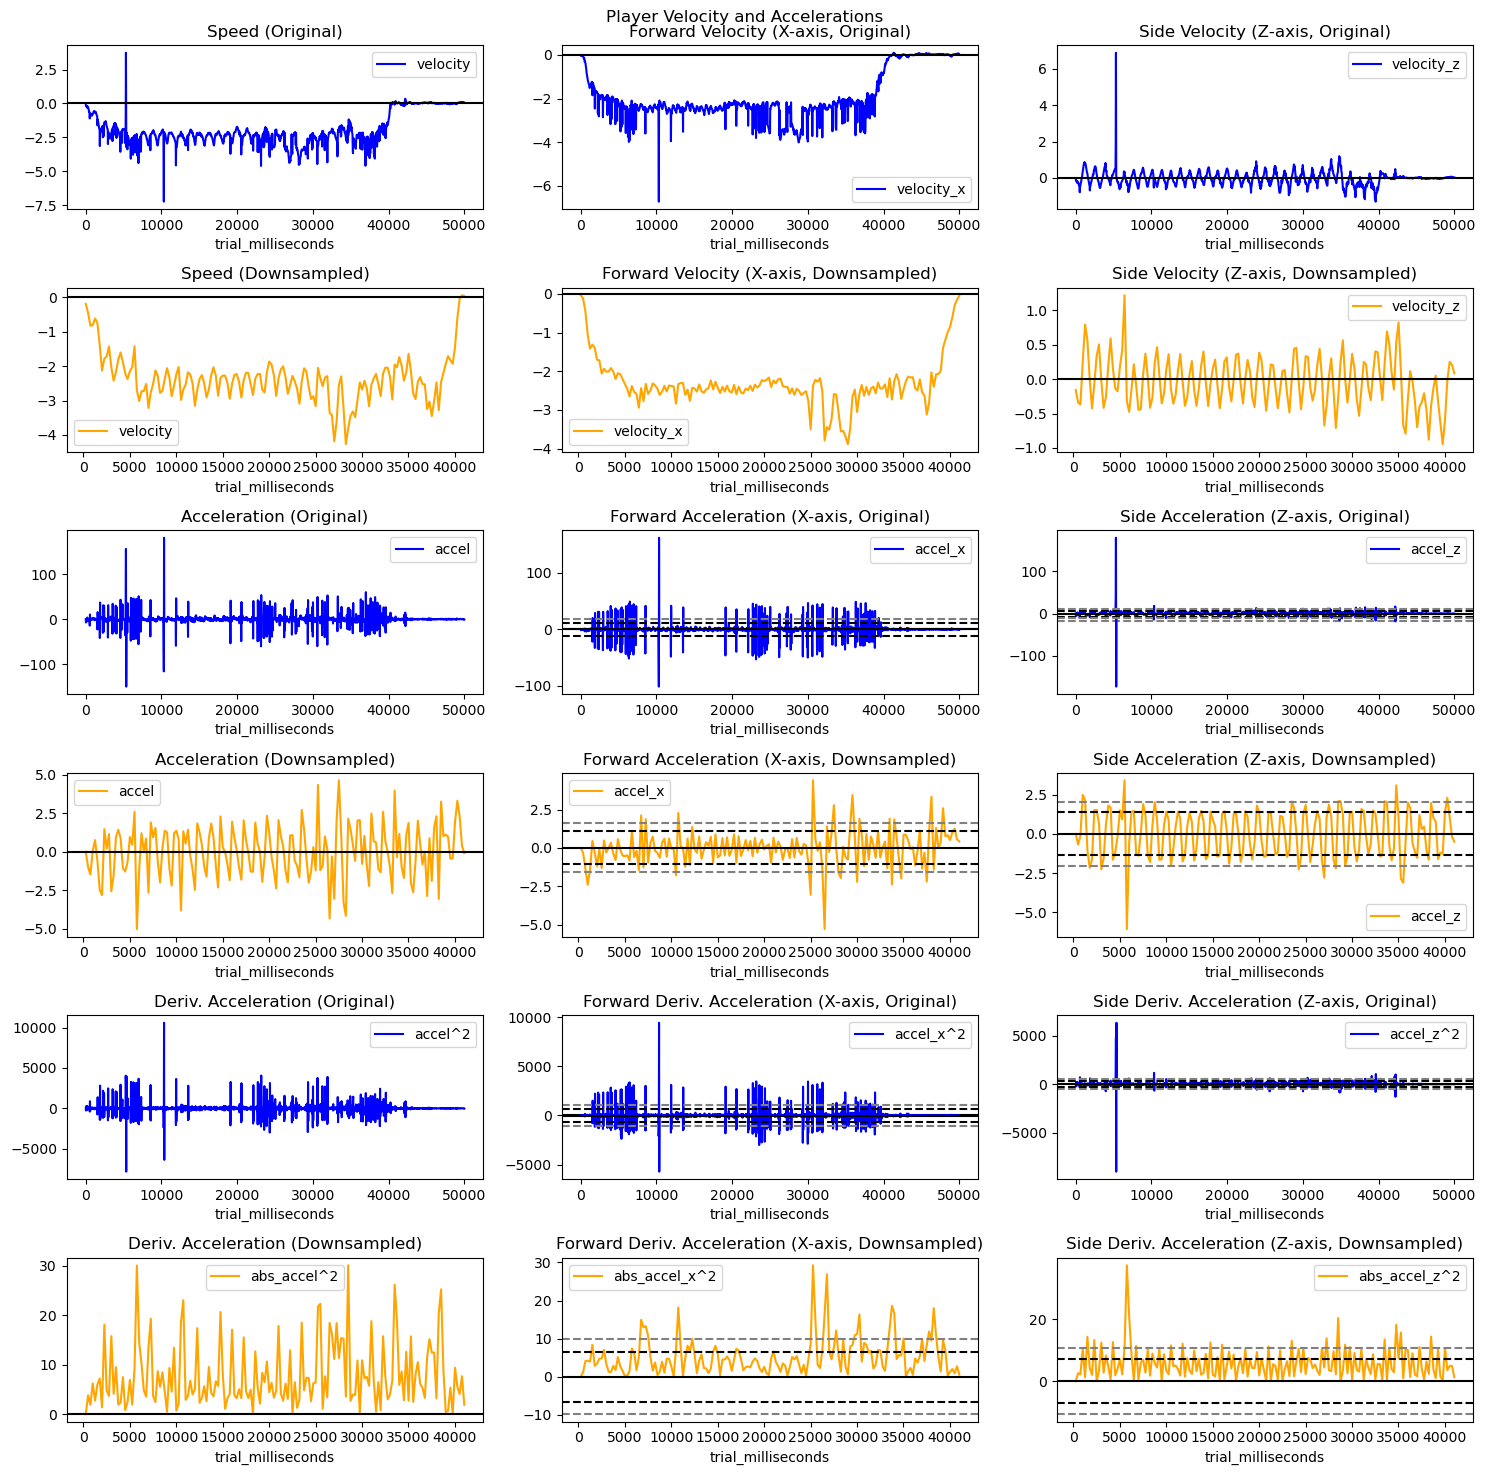

In [444]:
fig, axes = plt.subplots(nrows=6, ncols=3)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.suptitle('Player Velocity and Accelerations')

### Original Velocities
# Velocity (Speed)
user_df.plot.line(x='trial_milliseconds', y='velocity', ax=axes[0,0], title="Speed (Original)", color='blue')
axes[0,0].axhline(y=0, color='black', linestyle='-')
# Forward-Backward Velocity along X-axis
user_df.plot.line(x='trial_milliseconds', y='velocity_x', ax=axes[0,1], title="Forward Velocity (X-axis, Original)", color='blue')
axes[0,1].axhline(y=0, color='black', linestyle='-')
# Side-to-Side Velocity along Z-axis
user_df.plot.line(x='trial_milliseconds', y='velocity_z', ax=axes[0,2], title="Side Velocity (Z-axis, Original)", color='blue')
axes[0,2].axhline(y=0, color='black', linestyle='-')

### Downsampled Velocities
# Velocity (Speed)
player_df.plot.line(x='trial_milliseconds', y='velocity', ax=axes[1,0], title="Speed (Downsampled)", color='orange')
axes[1,0].axhline(y=0, color='black', linestyle='-')
# Forward-Backward Velocity along X-axis
player_df.plot.line(x='trial_milliseconds', y='velocity_x', ax=axes[1,1], title="Forward Velocity (X-axis, Downsampled)", color='orange')
axes[1,1].axhline(y=0, color='black', linestyle='-')
# Side-to-Side Velocity along Z-axis
player_df.plot.line(x='trial_milliseconds', y='velocity_z', ax=axes[1,2], title="Side Velocity (Z-axis, Downsampled)", color='orange')
axes[1,2].axhline(y=0, color='black', linestyle='-')

### Original Accelerations
# Acceleration
user_df.plot.line(x='trial_milliseconds', y='accel', ax=axes[2,0], title="Acceleration (Original)", color='blue')
axes[2,1].axhline(y=0, color='black', linestyle='-')
# Forward Acceleration along X-axis
user_df.plot.line(x='trial_milliseconds', y='accel_x', ax=axes[2,1], title="Forward Acceleration (X-axis, Original)", color='blue')
#axes[2,1].axhline(y=0, color='black', linestyle='-')
axes[2,1].axhline(y=orig_accel_x_mean, color='black', linestyle='-')
axes[2,1].axhline(y=orig_accel_x_std, color='black', linestyle='--')
axes[2,1].axhline(y=orig_accel_x_std*1.5, color='gray', linestyle='--') 
axes[2,1].axhline(y=-orig_accel_x_std, color='black', linestyle='--') 
axes[2,2].axhline(y=-orig_accel_x_std*1.5, color='gray', linestyle='--') 
# Side-to-Side Acceleration along Z-axis
user_df.plot.line(x='trial_milliseconds', y='accel_z', ax=axes[2,2], title="Side Acceleration (Z-axis, Original)", color='blue')
# axes[2,1].axhline(y=0, color='black', linestyle='-')
axes[2,2].axhline(y=orig_accel_z_mean, color='black', linestyle='-')
axes[2,2].axhline(y=orig_accel_z_std, color='black', linestyle='--')
axes[2,2].axhline(y=orig_accel_z_std*1.5, color='gray', linestyle='--') 
axes[2,2].axhline(y=-orig_accel_z_std, color='black', linestyle='--') 
axes[2,2].axhline(y=-orig_accel_z_std*1.5, color='gray', linestyle='--') 

### Downsampled Accelerations
# Forward Acceleration along X-axis
player_df.plot.line(x='trial_milliseconds', y='accel', ax=axes[3,0], title="Acceleration (Downsampled)", color='orange')
axes[3,0].axhline(y=0, color='black', linestyle='-')
# Forward Acceleration along X-axis
player_df.plot.line(x='trial_milliseconds', y='accel_x', ax=axes[3,1], title="Forward Acceleration (X-axis, Downsampled)", color='orange')
#axes[3,1].axhline(y=0, color='black', linestyle='-')
axes[3,1].axhline(y=accel_x_mean, color='black', linestyle='-')
axes[3,1].axhline(y=accel_x_std, color='black', linestyle='--')
axes[3,1].axhline(y=accel_x_std*1.5, color='gray', linestyle='--') 
axes[3,1].axhline(y=-accel_x_std, color='black', linestyle='--') 
axes[3,1].axhline(y=-accel_x_std*1.5, color='gray', linestyle='--') 
# Side-to-Side Acceleration along Z-axis
player_df.plot.line(x='trial_milliseconds', y='accel_z', ax=axes[3,2], title="Side Acceleration (Z-axis, Downsampled)", color='orange')
#axes[3,2].axhline(y=0, color='black', linestyle='-')
axes[3,2].axhline(y=accel_z_mean, color='black', linestyle='-')
axes[3,2].axhline(y=accel_z_std, color='black', linestyle='--')
axes[3,2].axhline(y=accel_z_std*1.5, color='gray', linestyle='--') 
axes[3,2].axhline(y=-accel_z_std, color='black', linestyle='--') 
axes[3,2].axhline(y=-accel_z_std*1.5, color='gray', linestyle='--') 

### Original Deriv. Accelerations
# Deriv. Acceleration
user_df.plot.line(x='trial_milliseconds', y='accel^2', ax=axes[4,0], title="Deriv. Acceleration (Original)", color='blue')
axes[4,1].axhline(y=0, color='black', linestyle='-')
# Forward Deriv. Acceleration along X-axis
user_df.plot.line(x='trial_milliseconds', y='accel_x^2', ax=axes[4,1], title="Forward Deriv. Acceleration (X-axis, Original)", color='blue')
#axes[4,1].axhline(y=0, color='black', linestyle='-')
axes[4,1].axhline(y=orig_accel_x2_mean, color='black', linestyle='-')
axes[4,1].axhline(y=orig_accel_x2_std, color='black', linestyle='--')
axes[4,1].axhline(y=orig_accel_x2_std*1.5, color='gray', linestyle='--') 
axes[4,1].axhline(y=-orig_accel_x2_std, color='black', linestyle='--') 
axes[4,1].axhline(y=-orig_accel_x2_std*1.5, color='gray', linestyle='--') 
# Side-to-Side Deriv. Acceleration along Z-axis
user_df.plot.line(x='trial_milliseconds', y='accel_z^2', ax=axes[4,2], title="Side Deriv. Acceleration (Z-axis, Original)", color='blue')
#axes[4,2].axhline(y=0, color='black', linestyle='-')
axes[4,2].axhline(y=orig_accel_z2_mean, color='black', linestyle='-')
axes[4,2].axhline(y=orig_accel_z2_std, color='black', linestyle='--')
axes[4,2].axhline(y=orig_accel_z2_std*1.5, color='gray', linestyle='--') 
axes[4,2].axhline(y=-orig_accel_z2_std, color='black', linestyle='--') 
axes[4,2].axhline(y=-orig_accel_z2_std*1.5, color='gray', linestyle='--') 

### Downsampled Deriv. Accelerations
# Deriv. Acceleration
player_df.plot.line(x='trial_milliseconds', y='abs_accel^2', ax=axes[5,0], title="Deriv. Acceleration (Downsampled)", color='orange')
axes[5,0].axhline(y=0, color='black', linestyle='-')
# Forward Deriv. Acceleration along X-axis
player_df.plot.line(x='trial_milliseconds', y='abs_accel_x^2', ax=axes[5,1], title="Forward Deriv. Acceleration (X-axis, Downsampled)", color='orange')
#axes[5,1].axhline(y=0, color='black', linestyle='-')
axes[5,1].axhline(y=accel_x2_mean, color='black', linestyle='-')
axes[5,1].axhline(y=accel_x2_std, color='black', linestyle='--')
axes[5,1].axhline(y=accel_x2_std*1.5, color='gray', linestyle='--') 
axes[5,1].axhline(y=-accel_x2_std, color='black', linestyle='--') 
axes[5,1].axhline(y=-accel_x2_std*1.5, color='gray', linestyle='--') 
# Side-to-Side Deriv. Acceleration along Z-axis
player_df.plot.line(x='trial_milliseconds', y='abs_accel_z^2', ax=axes[5,2], title="Side Deriv. Acceleration (Z-axis, Downsampled)", color='orange')
#axes[5,2].axhline(y=0, color='black', linestyle='-')
axes[5,2].axhline(y=accel_z2_mean, color='black', linestyle='-')
axes[5,2].axhline(y=accel_z2_std, color='black', linestyle='--')
axes[5,2].axhline(y=accel_z2_std*1.5, color='gray', linestyle='--') 
axes[5,2].axhline(y=-accel_z2_std, color='black', linestyle='--') 
axes[5,2].axhline(y=-accel_z2_std*1.5, color='gray', linestyle='--') 

"""
# Downsampled Jerks from User
# Deriv. Acceleration
user_jerked_df.plot.line(x='trial_milliseconds', y='accel', ax=axes[6,0], title="User Jerk (Downsampled)", color='blue')
axes[6,0].axhline(y=0, color='black', linestyle='-')
# Forward Deriv. Acceleration along X-axis
user_jerked_df.plot.line(x='trial_milliseconds', y='accel_x', ax=axes[6,1], title="User Forward Jerk (X-axis, Downsampled)", color='blue')
axes[6,1].axhline(y=0, color='black', linestyle='-')
# Side-to-Side Deriv. Acceleration along Z-axis
user_jerked_df.plot.line(x='trial_milliseconds', y='accel_z', ax=axes[6,2], title="User Side Jerk (Z-axis, Downsampled)", color='blue')
axes[6,2].axhline(y=0, color='black', linestyle='-')
"""

# Show plot
plt.tight_layout()
plt.show()

# Fixing Tangential Gait

In [361]:
user_raw_df = pd.read_csv(_ALIGNED_FILES['user-raw.csv'])
trial_df = pd.read_csv(_ALIGNED_FILES['trial.csv'])

user_raw_df['unix_ms'] = user_raw_df['unix_ms'].astype('Int64')
trial_df['unix_ms'] = trial_df['unix_ms'].astype('Int64')

display(user_raw_df)
display(trial_df)

trial_oscillation_start = trial_df[trial_df['event']=='Oscillator Started'].loc[1, 'unix_ms']
trial_oscillation_end = trial_df[trial_df['event']=='Countdown Started'].loc[2, 'unix_ms']

print(trial_oscillation_start, trial_oscillation_end)

,unix_ms,pos_x,pos_y,pos_z,forward_x,forward_y,forward_z,vel_x,vel_y,vel_z,...,leftHandVelocity_z,rightHandPos_x,rightHandPos_y,rightHandPos_z,rightHandForward_x,rightHandForward_y,rightHandForward_z,rightHandVelocity_x,rightHandVelocity_y,rightHandVelocity_z
0,1728510163266,2.116194,1.619398,-0.013481,-0.988670,0.147404,0.028356,0.000089,0.000957,-0.006600,...,0.200714,2.062250,0.654043,0.571713,-0.499893,-0.799615,-3.327518e-01,0.540250,0.118330,-0.685269
1,1728510163272,2.116194,1.619398,-0.013481,-0.988670,0.147404,0.028356,0.000000,0.000000,0.000000,...,0.000000,2.062250,0.654043,0.571713,-0.499893,-0.799615,-3.327518e-01,0.000000,0.000000,0.000000
2,1728510163277,2.116194,1.619398,-0.013481,-0.988670,0.147404,0.028356,0.000000,0.000000,0.000000,...,0.000000,2.062250,0.654043,0.571713,-0.499893,-0.799615,-3.327518e-01,0.000000,0.000000,0.000000
3,1728510163307,2.114258,1.619763,-0.014517,-0.988656,0.148516,0.022430,-0.145251,0.027385,-0.077666,...,-0.010921,2.099019,0.644269,0.542440,-0.557975,-0.747841,-3.597186e-01,2.757722,-0.733021,-2.195460
4,1728510163313,2.114258,1.619763,-0.014517,-0.988656,0.148516,0.022430,0.000000,0.000000,0.000000,...,0.000000,2.099019,0.644269,0.542440,-0.557975,-0.747841,-3.597186e-01,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3950,1728510215910,-39.070220,1.614918,-0.042614,0.985158,0.093226,0.144127,-0.021172,0.000465,0.007725,...,0.000000,2.500000,0.224970,0.000000,-1.000000,0.000000,-1.192093e-07,0.000000,0.000000,0.000000
3951,1728510215917,-39.070220,1.614918,-0.042614,0.985158,0.093226,0.144127,0.000000,0.000000,0.000000,...,0.000000,2.500000,0.224970,0.000000,-1.000000,0.000000,-1.192093e-07,0.000000,0.000000,0.000000
3952,1728510215995,-39.070330,1.614953,-0.042511,0.985060,0.093150,0.144845,-0.008583,0.002593,0.007725,...,0.000000,2.500000,0.224970,0.000000,-1.000000,0.000000,-1.192093e-07,0.000000,0.000000,0.000000
3953,1728510216010,-39.070330,1.614953,-0.042511,0.985060,0.093150,0.144845,0.000000,0.000000,0.000000,...,0.000000,2.500000,0.224970,0.000000,-1.000000,0.000000,-1.192093e-07,0.000000,0.000000,0.000000


,unix_ms,event
0,1728510070386,JayStreet Opened
1,1728510124168,Oscillator Started
2,1728510158240,Countdown Started
3,1728510163247,Participant Trial Started


1728510124168 1728510158240


In [215]:
print(trial_df.loc[1, 'unix_ms'], trial_df.loc[2, 'unix_ms'], trial_df.loc[2, 'unix_ms']-trial_df.loc[1, 'unix_ms'])
osci_df_1 = user_raw_df[user_raw_df['unix_ms'] >= trial_oscillation_start]
osci_df_2 = user_raw_df[user_raw_df['unix_ms'] < trial_oscillation_end]
#osci_df = user_raw_df[user_raw_df['unix_ms'] < (trial_df.loc[1, 'unix_ms'], trial_df.loc[2, 'unix_ms'])]
display(osci_df_1)
display(osci_df_2)

1728510124168 1728510158240 34072


,unix_ms,pos_x,pos_y,pos_z,forward_x,forward_y,forward_z,vel_x,vel_y,vel_z,...,leftHandVelocity_z,rightHandPos_x,rightHandPos_y,rightHandPos_z,rightHandForward_x,rightHandForward_y,rightHandForward_z,rightHandVelocity_x,rightHandVelocity_y,rightHandVelocity_z
0,1728510163266,2.116194,1.619398,-0.013481,-0.988670,0.147404,0.028356,0.000089,0.000957,-0.006600,...,0.200714,2.062250,0.654043,0.571713,-0.499893,-0.799615,-3.327518e-01,0.540250,0.118330,-0.685269
1,1728510163272,2.116194,1.619398,-0.013481,-0.988670,0.147404,0.028356,0.000000,0.000000,0.000000,...,0.000000,2.062250,0.654043,0.571713,-0.499893,-0.799615,-3.327518e-01,0.000000,0.000000,0.000000
2,1728510163277,2.116194,1.619398,-0.013481,-0.988670,0.147404,0.028356,0.000000,0.000000,0.000000,...,0.000000,2.062250,0.654043,0.571713,-0.499893,-0.799615,-3.327518e-01,0.000000,0.000000,0.000000
3,1728510163307,2.114258,1.619763,-0.014517,-0.988656,0.148516,0.022430,-0.145251,0.027385,-0.077666,...,-0.010921,2.099019,0.644269,0.542440,-0.557975,-0.747841,-3.597186e-01,2.757722,-0.733021,-2.195460
4,1728510163313,2.114258,1.619763,-0.014517,-0.988656,0.148516,0.022430,0.000000,0.000000,0.000000,...,0.000000,2.099019,0.644269,0.542440,-0.557975,-0.747841,-3.597186e-01,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3950,1728510215910,-39.070220,1.614918,-0.042614,0.985158,0.093226,0.144127,-0.021172,0.000465,0.007725,...,0.000000,2.500000,0.224970,0.000000,-1.000000,0.000000,-1.192093e-07,0.000000,0.000000,0.000000
3951,1728510215917,-39.070220,1.614918,-0.042614,0.985158,0.093226,0.144127,0.000000,0.000000,0.000000,...,0.000000,2.500000,0.224970,0.000000,-1.000000,0.000000,-1.192093e-07,0.000000,0.000000,0.000000
3952,1728510215995,-39.070330,1.614953,-0.042511,0.985060,0.093150,0.144845,-0.008583,0.002593,0.007725,...,0.000000,2.500000,0.224970,0.000000,-1.000000,0.000000,-1.192093e-07,0.000000,0.000000,0.000000
3953,1728510216010,-39.070330,1.614953,-0.042511,0.985060,0.093150,0.144845,0.000000,0.000000,0.000000,...,0.000000,2.500000,0.224970,0.000000,-1.000000,0.000000,-1.192093e-07,0.000000,0.000000,0.000000


,unix_ms,pos_x,pos_y,pos_z,forward_x,forward_y,forward_z,vel_x,vel_y,vel_z,...,leftHandVelocity_z,rightHandPos_x,rightHandPos_y,rightHandPos_z,rightHandForward_x,rightHandForward_y,rightHandForward_z,rightHandVelocity_x,rightHandVelocity_y,rightHandVelocity_z


# Damien's Method

In [137]:
_ALIGNED_DIR = './samples/participant_data_aligned/'
def find_velocity_change():
    def downsample_user(participant, trial):
        user_aligned = pd.read_csv(f'./samples/participant_data_aligned/{participant}/{trial}/user-aligned.csv')
                
        columns_to_downsample = ['pos_x', 'pos_y', 'pos_z', 'rel_pos_x',
        'rel_pos_y', 'rel_pos_z', 'forward_x', 'forward_y', 'forward_z',
        'rel_forward_x', 'rel_forward_y', 'rel_forward_z', 'velocity_x',
        'velocity_y', 'velocity_z', 'rel_velocity_x', 'rel_velocity_y',
        'rel_velocity_z', 'angle_from_participant', 'distance_from_participant']

        user_aligned['adjusted'] = user_aligned['trial_milliseconds'] - user_aligned['trial_milliseconds'].min()

        time_bins = range(0, user_aligned['adjusted'].max() + 1000, 1000)

        user_aligned['time_bin'] = pd.cut(user_aligned['adjusted'], bins=time_bins, right=False, labels=time_bins[:-1])

        user_aligned = user_aligned.groupby('time_bin')[columns_to_downsample].mean().reset_index()
        initial_vel_x = user_aligned.loc[0, 'velocity_x'] if 'velocity_x' in user_aligned.columns else 0
        initial_vel_z = user_aligned.loc[0, 'velocity_z'] if 'velocity_z' in user_aligned.columns else 0

        user_aligned['velocity_x'] = user_aligned['pos_x'].diff()
        user_aligned['velocity_z'] = user_aligned['pos_z'].diff()

        user_aligned['velocity_x'].iloc[0] = initial_vel_x
        user_aligned['velocity_z'].iloc[0] = initial_vel_z

        user_aligned['acceleration_x'] = user_aligned['velocity_x'].diff()
        user_aligned['acceleration_z'] = user_aligned['velocity_z'].diff()

        user_aligned['acceleration_x'].iloc[0] = 0
        user_aligned['acceleration_z'].iloc[0] = 0

        user_aligned['acceleration'] = np.sqrt(user_aligned['acceleration_x']**2 + 
                                                    user_aligned['acceleration_z']**2)

        forward_magnitude = np.sqrt(user_aligned['forward_x']**2 + user_aligned['forward_z']**2)
        user_aligned['norm_forward_x'] = user_aligned['forward_x'] / forward_magnitude
        user_aligned['norm_forward_z'] = user_aligned['forward_z'] / forward_magnitude

        def calculate_forward_velocity(row):
            dot_product = row['velocity_x'] * row['norm_forward_x'] + row['velocity_z'] * row['norm_forward_z']
            return pd.Series([dot_product * row['norm_forward_x'], dot_product * row['norm_forward_z']])

        user_aligned[['forward_velocity_x', 'forward_velocity_z']] = user_aligned.apply(calculate_forward_velocity, axis=1)

        user_aligned['forward_speed'] = np.sqrt(user_aligned['forward_velocity_x']**2 + user_aligned['forward_velocity_z']**2)

        user_aligned['forward_acceleration_x'] = user_aligned['forward_velocity_x'].diff()
        user_aligned['forward_acceleration_z'] = user_aligned['forward_velocity_z'].diff()
        user_aligned['forward_acceleration_x'].iloc[0] = 0
        user_aligned['forward_acceleration_z'].iloc[0] = 0

        user_aligned['forward_acceleration'] = np.sqrt(user_aligned['forward_acceleration_x']**2 + 
                                                    user_aligned['forward_acceleration_z']**2)
        
        user_aligned.drop(['norm_forward_x', 'norm_forward_z'], axis=1, inplace=True)

        return user_aligned
        

    test = downsample_user('p1', 'jay-vr-2')
    vel_change = pd.DataFrame(columns=list(test.columns) + ['participant', 'trial'])

    def velocity_change(participant, trial, vel_change):
        user_aligned = downsample_user(participant, trial)
        user_aligned['participant'] = participant
        user_aligned['trial'] = trial

        mean_forward_acceleration = user_aligned['forward_acceleration'].mean()

        filtered = user_aligned[user_aligned['forward_acceleration'] > mean_forward_acceleration]

        return pd.concat([vel_change, filtered], ignore_index=True, sort=False)

    participant_directories = get_immediate_subdirectories(_ALIGNED_DIR)
    participant_directories.sort()

    trial_directories = {pdir:get_immediate_subdirectories(os.path.join(_ALIGNED_DIR,pdir)) for pdir in participant_directories}
    trial_directories

    trial_files = {pdir:{td:get_immediate_files(os.path.join(os.path.join(_ALIGNED_DIR, pdir),td)) for td in trial_directories[pdir]} for pdir in trial_directories}

    for pdir in trial_files:
        for tdir in trial_files[pdir]:
            vel_change = velocity_change(pdir, tdir, vel_change)
            print('processed ' + pdir + ' ' + tdir)

    cols = vel_change.columns.tolist()
    vel_change = vel_change[[cols[-2], cols[-1]] + cols[:-2]]
    
    return vel_change

In [126]:
damien = find_velocity_change()

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_54956/662289807.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_aligned = user_aligned.groupby('time_bin')[columns_to_downsample].mean().reset_index()
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_54956/662289807.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexe

processed p1 jay-vr-2
processed p1 jay-vr-1
processed p10 jay-vr-2
processed p10 jay-vr-3
processed p10 jay-vr-1
processed p11 jay-vr-2
processed p11 jay-vr-3
processed p11 jay-vr-1
processed p12 jay-vr-2
processed p12 jay-vr-3
processed p12 jay-vr-1
processed p13 jay-vr-2
processed p13 jay-vr-3
processed p13 jay-vr-1
processed p14 jay-vr-2
processed p14 jay-vr-3
processed p14 jay-vr-1
processed p15 jay-vr-5
processed p15 jay-vr-2
processed p15 jay-vr-3


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_54956/662289807.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_aligned = user_aligned.groupby('time_bin')[columns_to_downsample].mean().reset_index()
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_54956/662289807.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexe

processed p15 jay-vr-4
processed p15 jay-vr-1
processed p16 jay-vr-2
processed p16 jay-vr-3
processed p16 jay-vr-4
processed p16 jay-vr-1
processed p17 jay-vr-2
processed p17 jay-vr-3
processed p17 jay-vr-1
processed p18 jay-vr-2
processed p18 jay-vr-3
processed p18 jay-vr-1
processed p2 jay-vr-4
processed p2 jay-vr-1
processed p3 jay-vr-2
processed p3 jay-vr-3
processed p3 jay-vr-1
processed p4 jay-vr-5
processed p4 jay-vr-4
processed p5 jay-vr-2
processed p5 jay-vr-1
processed p6 jay-vr-2
processed p6 jay-vr-1
processed p7 jay-vr-2
processed p7 jay-vr-1
processed p8 jay-vr-2
processed p8 jay-vr-3
processed p8 jay-vr-1
processed p9 jay-vr-2
processed p9 jay-vr-1


/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_54956/662289807.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_aligned = user_aligned.groupby('time_bin')[columns_to_downsample].mean().reset_index()
/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_54956/662289807.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexe

In [131]:
damien_sample = damien[(damien['participant']=='p1') & (damien['trial']=='jay-vr-2')]

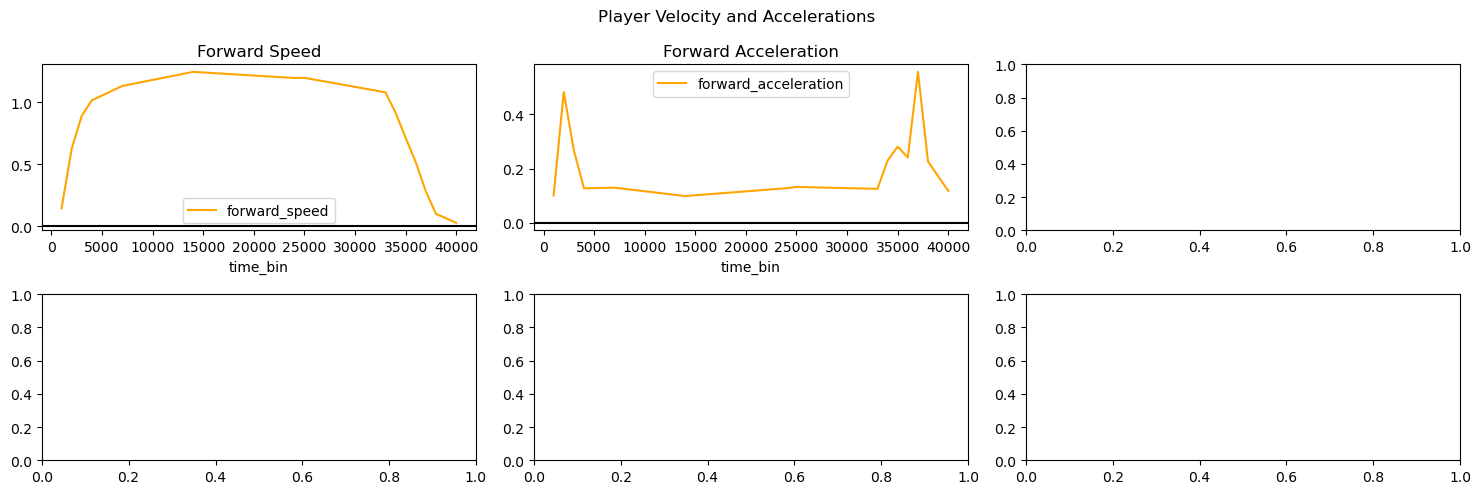

In [132]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle('Player Velocity and Accelerations')

### Downsampled Velocities
# Velocity (Speed)
damien_sample.plot.line(x='time_bin', y='forward_speed', ax=axes[0,0], title="Forward Speed", color='orange')
axes[0,0].axhline(y=0, color='black', linestyle='-')

# Velocity (Speed)
damien_sample.plot.line(x='time_bin', y='forward_acceleration', ax=axes[0,1], title="Forward Acceleration", color='orange')
axes[0,1].axhline(y=0, color='black', linestyle='-')

"""
# Forward-Backward Velocity along X-axis
p1_t1.plot.line(x='trial_milliseconds', y='velocity_x', ax=axes[1,1], title="Forward Velocity (X-axis, Downsampled)", color='orange')
axes[1,1].axhline(y=0, color='black', linestyle='-')
# Side-to-Side Velocity along Z-axis
p1_t1.plot.line(x='trial_milliseconds', y='velocity_z', ax=axes[1,2], title="Side Velocity (Z-axis, Downsampled)", color='orange')
axes[1,2].axhline(y=0, color='black', linestyle='-')

### Downsampled Accelerations
# Forward Acceleration along X-axis
p1_t1.plot.line(x='trial_milliseconds', y='accel', ax=axes[3,0], title="Acceleration (Downsampled)", color='orange')
axes[3,1].axhline(y=0, color='black', linestyle='-')
# Forward Acceleration along X-axis
p1_t1.plot.line(x='trial_milliseconds', y='accel_x', ax=axes[3,1], title="Forward Acceleration (X-axis, Downsampled)", color='orange')
axes[3,1].axhline(y=0, color='black', linestyle='-')
# Side-to-Side Acceleration along Z-axis
p1_t1.plot.line(x='trial_milliseconds', y='accel_z', ax=axes[3,2], title="Side Acceleration (Z-axis, Downsampled)", color='orange')
axes[3,2].axhline(y=0, color='black', linestyle='-')
"""

# Show plot
plt.tight_layout()
plt.show()